# Ultimate Inc Take Home Challenge, Daniel Loew, Springboard

# Part II: Experiment and Metrics design
# Part III: Predictive Modeling

The Ultimate Inc take-home challenge focuses on examining usage patterns, driver behavior, and rider retention for a large taxi alternative company called Ultimate Inc. This second notebook first lays out the design of an experiment to determine if a new company policy reimbursing drivers for their bridge tolls between the fictional cities of Gotham and Metropolis changes driver behavior to increase rides between the cities. This notebook then creates a data science pipeline which predicts rider retention and details which features are most predictive of rider retention.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle

In [2]:
data_path = '/Users/DanLoew/Documents/Academia/Springboard/DSCT/17.2.2 Ultimate Technologies Take Home Challenge/ultimate_challenge/ultimate_data_challenge.json'

In [3]:
buf = open(data_path)
buf

<_io.TextIOWrapper name='/Users/DanLoew/Documents/Academia/Springboard/DSCT/17.2.2 Ultimate Technologies Take Home Challenge/ultimate_challenge/ultimate_data_challenge.json' mode='r' encoding='UTF-8'>

In [4]:
obj = json.load(buf)
obj[:3]

[{'city': "King's Landing",
  'trips_in_first_30_days': 4,
  'signup_date': '2014-01-25',
  'avg_rating_of_driver': 4.7,
  'avg_surge': 1.1,
  'last_trip_date': '2014-06-17',
  'phone': 'iPhone',
  'surge_pct': 15.4,
  'ultimate_black_user': True,
  'weekday_pct': 46.2,
  'avg_dist': 3.67,
  'avg_rating_by_driver': 5.0},
 {'city': 'Astapor',
  'trips_in_first_30_days': 0,
  'signup_date': '2014-01-29',
  'avg_rating_of_driver': 5.0,
  'avg_surge': 1.0,
  'last_trip_date': '2014-05-05',
  'phone': 'Android',
  'surge_pct': 0.0,
  'ultimate_black_user': False,
  'weekday_pct': 50.0,
  'avg_dist': 8.26,
  'avg_rating_by_driver': 5.0},
 {'city': 'Astapor',
  'trips_in_first_30_days': 3,
  'signup_date': '2014-01-06',
  'avg_rating_of_driver': 4.3,
  'avg_surge': 1.0,
  'last_trip_date': '2014-01-07',
  'phone': 'iPhone',
  'surge_pct': 0.0,
  'ultimate_black_user': False,
  'weekday_pct': 100.0,
  'avg_dist': 0.77,
  'avg_rating_by_driver': 5.0}]

In [5]:
df = pd.DataFrame(obj)

In [6]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


# Part II: Experiment and Metrics design

## The Challenge:

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

    a. how you will implement the experiment
    b. what statistical test(s) you will conduct to verify the significance of the observation
    c. how you would interpret the results and provide recommendations to the city operations team along with any        caveats

The key measure of success would be if Gotham drivers start driving in Metropolis, and if Metropolis drivers start driving in Gotham. 

I would first look at the percentage of trips that ended in Gotham for each driver, and the percentage of trips that ended in Metropolis for each driver. So you need the destination points of each trip. You would get these percentages for the month before the toll reimbursement plan was installed, and for the month after.

For the month before the toll reimbursement plan was installed, I would label each driver as either a “pre-change Gotham driver” if more than 50% of their trips in that month had their destination in Gotham, or a “pre-change Metropolis driver” if more than 50% of their trips in that month had their destination in Metropolis. 

For the month after the toll reimbursement plan was installed, I would label each driver as either a “post-change Gotham driver” if more than 50% of their trips in that month had their destination in Gotham, or a “post-change Metropolis driver” if more than 50% of their trips in that month had their destination in Metropolis. 

I would then label all drivers who flipped from “pre-change Gotham drivers” to “post-change Metropolis drivers” or “pre-change Metropolis drivers” to “post-change Metropolis drivers” as “flippers”. Those who did not flip would be called “non-flippers”.

I would then run a z-test with the following components: percentage_flippers, standard_deviation_flippers, n_flippers, percentage_non_flippers, standard_deviation_non_flippers, and n_non_flippers. 

The null hypothesis would be that the difference between flippers and non-flippers is due to chance. 

If the p-value is less than 5%, the null hypothesis would be rejected and one would have to say that the difference between flippers and non-flppers is not due to chance. 

Although it is not a totally controlled experiment, all variables under Ultimate's control would be held constant between the month before and after the reimbursement policy change. The only major difference between the two months is that Ultimate started reimbursing toll charges to its drivers. 

The z-test is ran instead of the t-test because we are dealing with the whole universe of drivers, not a sample.

If the null hypothesis is rejected, Ultimate can say that the change in their policy of reimbursing toll charges to its drivers is responsible for the change of drivers flipping to majority Gotham or majority Metropolis drivers. 

If the null hypothesis is rejected, Ultimate can say that the policy change is worth it and that it should continue. If it is not rejected, then Ultimate’s policy change of reimbursing toll charges to its drivers should be canceled. 

One caveat is that Ultimate may wish to change the time period from one month to longer, although if that is done, the time periods between considered before and after the change should be equal.

An important factor in the success of this experiment would be that the policy change of reimbursing drivers for the bridge tolls must be loudly publicized. It even would be worth it to Ultimate to make each driver fully read and verify that they’ve understood clear language about the policy change, translated into multiple languages. 

After they sign that they’ve understood the policy change, a one-question survey should be run requiring them to choose the correct answer of a multiple choice question, validating that they understand the change. No questions about whether they will choose to get reimbursed for polls or change their driving habits can be asked, as Ultimate would not wish to lead their drivers’ behavior and bias the results of the experiment.

# Part III: Predictive Modeling

## Assessing Data Quality

Before conducting EDA and building the machine learning model, the DataFrame needs to be inspected for missing values, erroneous values, and potential sources of data leakage.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [8]:
df.describe(include='all')

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000,50000,49604,50000,50000.000000,50000.000000,50000,50000.000000
unique,NaN,NaN,NaN,NaN,3,182,2,31,NaN,NaN,2,NaN
top,NaN,NaN,NaN,NaN,Winterfell,2014-06-29,iPhone,2014-01-18,NaN,NaN,False,NaN
freq,NaN,NaN,NaN,NaN,23336,2036,34582,2948,NaN,NaN,31146,NaN
mean,5.796827,4.778158,4.601559,1.074764,NaN,NaN,NaN,NaN,8.849536,2.278200,NaN,60.926084
std,5.707357,0.446652,0.617338,0.222336,NaN,NaN,NaN,NaN,19.958811,3.792684,NaN,37.081503
min,0.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000
25%,2.420000,4.700000,4.300000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,33.300000
50%,3.880000,5.000000,4.900000,1.000000,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN,66.700000
75%,6.940000,5.000000,5.000000,1.050000,NaN,NaN,NaN,NaN,8.600000,3.000000,NaN,100.000000


In [9]:
df.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
dtype: int64

In [10]:
df.isna().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
dtype: int64

As can be seen above, the feature describing the average rider rating ('avg_rating_by_driver') has 201 rows with missing values, the feature describing the average driver rating ('avg_rating_of_driver') has 8,122 rows with missing values, and the feature describing the primary type of device a user uses ('phone') has 396 rows with missing values.

The median value of the 'avg_rating_by_driver' and 'avg_rating_of_driver' features will be used to fill in the missing values for each of these features, respectively. The 'phone' feature is categorical and will need to be binarized in order for it to be included in the machine learning feature set, so before that happens any missing values will be filled in with an 'unknown_device' value, which will then become its own binary feature along with the other values for 'phone'.

For each of the three features with missing values, a partner binary feature will be created which will flag which rows had their missing values filled in.

In [11]:
null_value_columns = list(df.columns[(df.isnull().sum()>0) | (df.isna().sum()>0)])
null_value_columns

['avg_rating_by_driver', 'avg_rating_of_driver', 'phone']

In [12]:
for col_name in null_value_columns:
    new_col_name = col_name+'_isnull'
    print(col_name)
    df[new_col_name] = df[col_name].isnull()

avg_rating_by_driver
avg_rating_of_driver
phone


In [13]:
df.head(1)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,avg_rating_by_driver_isnull,avg_rating_of_driver_isnull,phone_isnull
0,3.67,5.0,4.7,1.1,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,False,False,False


In [14]:
avg_rating_by_driver_median = df['avg_rating_by_driver'].median()
avg_rating_by_driver_median

5.0

In [15]:
avg_rating_of_driver_median = df['avg_rating_of_driver'].median()
avg_rating_of_driver_median

4.9

In [16]:
fill_na_col_unknown = ['phone']

In [17]:
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(value = avg_rating_by_driver_median)

In [18]:
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(value = avg_rating_of_driver_median)

In [19]:
df[fill_na_col_unknown] = df[fill_na_col_unknown].fillna(value='unknown_device', axis=1)

All missing values have been filled with the appropriate value.

In [20]:
null_value_columns = list(df.columns[(df.isnull().sum()>0) | (df.isna().sum()>0)])
null_value_columns

[]

Frequency distributions of all features are examined for obviously erroneous values.

In [21]:
df['avg_dist'].value_counts()

0.00     150
2.30     116
2.29     116
2.70     114
2.36     114
2.73     114
2.65     113
2.50     113
2.83     110
2.54     110
2.40     110
2.15     109
2.05     109
2.42     109
2.32     108
2.62     108
2.47     107
2.01     107
2.89     107
2.74     107
3.05     106
2.60     106
2.06     106
3.00     106
2.59     106
2.77     105
2.22     104
2.92     104
2.38     103
2.46     103
        ... 
24.05      1
30.27      1
33.55      1
25.81      1
31.22      1
23.55      1
36.63      1
45.56      1
21.75      1
31.78      1
30.22      1
20.20      1
33.77      1
29.35      1
29.53      1
19.82      1
18.54      1
19.62      1
25.65      1
49.45      1
23.91      1
0.17       1
42.66      1
25.92      1
21.79      1
55.60      1
21.19      1
22.45      1
26.94      1
46.02      1
Name: avg_dist, Length: 2908, dtype: int64

In [22]:
df['avg_rating_by_driver'].value_counts()

5.0    28709
4.8     4537
4.7     3330
4.9     3094
4.5     2424
4.6     2078
4.0     1914
4.3     1018
4.4      860
3.0      602
4.2      342
3.5      199
3.7      195
1.0      181
2.0      126
4.1      125
3.8      111
3.3       47
3.9       41
2.5       31
3.6       19
3.4        5
1.5        4
2.8        3
3.2        2
2.7        2
2.3        1
Name: avg_rating_by_driver, dtype: int64

In [23]:
df['avg_rating_of_driver'].value_counts()

5.0    20771
4.9     9893
4.0     4193
4.5     2498
4.8     2430
4.7     1945
4.3     1487
4.6     1143
3.0     1003
4.4      829
4.2      601
3.5      488
3.8      428
4.1      398
3.7      364
1.0      256
3.9      255
2.0      209
3.3      201
3.6      172
3.4      108
2.5       94
3.2       53
2.7       47
3.1       39
2.8       28
2.3       22
2.9       13
2.6       12
2.1        6
1.5        4
2.4        3
1.8        2
1.7        2
2.2        1
1.6        1
1.9        1
Name: avg_rating_of_driver, dtype: int64

In [24]:
df['avg_surge'].value_counts()

1.00    34454
1.25     1100
1.13      956
1.02      809
1.08      798
1.04      774
1.06      770
1.05      704
1.03      619
1.07      616
1.10      508
1.50      505
1.01      484
1.17      473
1.11      446
1.09      412
1.15      367
1.14      340
1.19      327
1.75      296
1.38      294
2.00      261
1.16      255
1.20      243
1.18      217
1.21      214
1.33      200
1.12      196
1.22      163
1.31      136
        ...  
2.08        4
1.66        4
1.59        4
1.61        4
1.85        3
1.53        3
2.33        3
1.49        3
1.64        3
1.68        3
2.88        2
1.78        2
2.17        2
1.96        2
2.67        2
2.10        2
8.00        1
2.07        1
2.31        1
2.20        1
1.51        1
1.77        1
2.44        1
2.19        1
3.63        1
1.90        1
1.79        1
5.75        1
2.42        1
4.75        1
Name: avg_surge, Length: 115, dtype: int64

In [25]:
df['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [26]:
df['last_trip_date'].value_counts()

2014-06-29    2036
2014-06-28    1679
2014-06-30    1408
2014-06-27    1120
2014-06-22    1024
2014-06-21     869
2014-01-19     848
2014-01-26     808
2014-06-26     793
2014-06-14     665
2014-06-15     647
2014-06-20     612
2014-06-25     603
2014-01-25     601
2014-01-12     586
2014-01-20     557
2014-07-01     548
2014-06-23     546
2014-01-18     542
2014-06-07     534
2014-06-08     527
2014-06-01     494
2014-02-01     478
2014-05-18     470
2014-06-19     455
2014-06-24     440
2014-01-11     440
2014-06-13     438
2014-05-31     419
2014-06-18     400
              ... 
2014-04-03     109
2014-02-13     108
2014-04-22     105
2014-03-31     104
2014-02-10     104
2014-03-13     104
2014-02-05     104
2014-02-12     104
2014-03-24     103
2014-04-09     103
2014-04-16     102
2014-04-02      99
2014-02-18      99
2014-04-14      98
2014-03-05      91
2014-03-25      89
2014-02-04      87
2014-03-12      86
2014-03-03      84
2014-04-01      84
2014-04-15      83
2014-02-11  

In [27]:
df['phone'].value_counts()

iPhone            34582
Android           15022
unknown_device      396
Name: phone, dtype: int64

In [28]:
df['signup_date'].value_counts()

2014-01-18    2948
2014-01-25    2885
2014-01-11    2402
2014-01-24    2284
2014-01-17    2149
2014-01-31    2100
2014-01-19    2028
2014-01-10    2021
2014-01-06    1763
2014-01-01    1737
2014-01-26    1708
2014-01-23    1606
2014-01-07    1486
2014-01-04    1485
2014-01-30    1471
2014-01-09    1433
2014-01-16    1431
2014-01-22    1369
2014-01-05    1343
2014-01-12    1334
2014-01-20    1295
2014-01-28    1284
2014-01-08    1275
2014-01-27    1236
2014-01-21    1234
2014-01-03    1213
2014-01-29    1197
2014-01-14    1120
2014-01-15    1110
2014-01-13    1049
2014-01-02    1004
Name: signup_date, dtype: int64

In [29]:
df['surge_pct'].value_counts()

0.0      34409
100.0     1416
50.0      1367
33.3      1152
25.0       906
20.0       790
16.7       708
14.3       533
12.5       439
11.1       393
10.0       335
9.1        293
8.3        256
7.7        220
22.2       212
7.1        206
40.0       202
28.6       189
66.7       168
6.3        161
18.2       159
6.7        150
5.9        140
15.4       134
11.8       117
5.6        115
5.3        103
13.3       100
5.0         82
4.8         80
         ...  
23.0         1
48.1         1
55.0         1
42.4         1
33.6         1
33.7         1
64.7         1
14.9         1
35.5         1
37.2         1
28.8         1
38.2         1
30.3         1
47.8         1
30.6         1
26.4         1
9.9          1
18.7         1
27.9         1
28.2         1
59.5         1
29.3         1
62.5         1
0.6          1
0.4          1
34.6         1
35.2         1
45.8         1
52.9         1
63.6         1
Name: surge_pct, Length: 367, dtype: int64

In [30]:
type(df['surge_pct'][0])

numpy.float64

In [31]:
df['trips_in_first_30_days'].value_counts()

0      15390
1      14108
2       7402
3       3788
4       2562
5       1616
6       1134
7        819
8        589
9        471
10       349
11       301
12       221
13       168
15       155
14       147
17       113
16       108
18        80
19        69
20        51
23        45
21        40
22        34
24        33
27        28
28        21
25        20
26        19
30        15
34        11
29         9
33         9
37         9
32         8
31         6
44         5
40         5
38         4
43         4
47         3
42         3
36         3
39         3
53         2
55         2
56         2
54         2
48         2
49         2
35         2
125        1
73         1
58         1
71         1
41         1
50         1
51         1
63         1
Name: trips_in_first_30_days, dtype: int64

In [32]:
df['ultimate_black_user'].value_counts()

False    31146
True     18854
Name: ultimate_black_user, dtype: int64

In [33]:
df['weekday_pct'].value_counts()

100.0    16659
0.0       9203
50.0      4057
66.7      2088
33.3      1619
75.0      1104
60.0       772
25.0       723
80.0       668
40.0       593
83.3       401
71.4       395
57.1       395
20.0       343
42.9       284
85.7       281
62.5       256
87.5       241
55.6       221
44.4       210
37.5       196
16.7       196
77.8       193
28.6       175
70.0       171
63.6       166
88.9       162
58.3       158
54.5       151
72.7       143
         ...  
35.1         1
62.4         1
21.9         1
23.7         1
53.0         1
58.2         1
37.7         1
19.2         1
83.1         1
12.0         1
95.3         1
47.3         1
55.4         1
42.0         1
97.8         1
32.4         1
31.7         1
18.5         1
13.0         1
28.2         1
81.9         1
9.5          1
29.5         1
35.4         1
38.0         1
5.9          1
93.2         1
42.6         1
39.0         1
49.1         1
Name: weekday_pct, Length: 666, dtype: int64

There are no erroneous values that need to be corrected.

There are also no features that need to be dropped due to data leakage concerns, as none of the features contain the same information as the target variable 'retained', which stores info on whether or not users took a trip in the preceding 30 days.

## Creation of Target Variable

The target variable is 'retained', storing whether or not users took a trip in the preceding 30 days. 

In [34]:
df['last_trip_date'].value_counts().index.sort_values()

Index(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04', '2014-01-05',
       '2014-01-06', '2014-01-07', '2014-01-08', '2014-01-09', '2014-01-10',
       ...
       '2014-06-22', '2014-06-23', '2014-06-24', '2014-06-25', '2014-06-26',
       '2014-06-27', '2014-06-28', '2014-06-29', '2014-06-30', '2014-07-01'],
      dtype='object', length=182)

The final trip date in the DataFrame is '2014-07-01'. A user is considered 'retained' if their last trip was in the preceding 30 days, which means later than June 1st, 2014. A boolean mask is first created, and then a new target feature is created using this boolean mask.

In [35]:
retained = df.last_trip_date > '2014-06-01'

In [36]:
df['retained'] = retained.astype(int)
df['retained'].value_counts()

0    31690
1    18310
Name: retained, dtype: int64

The creation of the target feature shows us that 18,310 out of 50,000 users took a trip in the last 30 days, or 37%. This is a problematic percentage for Ultimate, which they can address from the findings of this machine learning classification model.

A frequency distribution of 'last_trip_date' and 'retained' is run to verify that the definition condition of 'retained' worked correctly. It did.

In [37]:
df[['last_trip_date', 'retained']]

,last_trip_date,retained
0,2014-06-17,1
1,2014-05-05,0
2,2014-01-07,0
3,2014-06-29,1
4,2014-03-15,0
5,2014-06-06,1
6,2014-01-25,0
7,2014-01-29,0
8,2014-02-01,0
9,2014-01-05,0


## Transformation of Date Features for Machine Learning Purposes

The date features are unpacked into component integer features, as that is the only way they will be processed by the machine learning model.

In [38]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['signup_date'].head(1)

0   2014-01-25
Name: signup_date, dtype: datetime64[ns]

In [39]:
type(df['signup_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [40]:
df['signup_year'] = df['signup_date'].dt.year
df['signup_year'].head(1)

0    2014
Name: signup_year, dtype: int64

In [41]:
df['signup_month'] = df['signup_date'].dt.month
df['signup_month'].head(1)

0    1
Name: signup_month, dtype: int64

In [42]:
df['signup_day'] = df['signup_date'].dt.day
df['signup_day'].head(1)

0    25
Name: signup_day, dtype: int64

In [43]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['last_trip_date'].head(1)

0   2014-06-17
Name: last_trip_date, dtype: datetime64[ns]

In [44]:
type(df['last_trip_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [45]:
df['last_trip_year'] = df['last_trip_date'].dt.year
df['last_trip_year'].head(1)

0    2014
Name: last_trip_year, dtype: int64

In [46]:
df['last_trip_month'] = df['last_trip_date'].dt.month
df['last_trip_month'].head(1)

0    6
Name: last_trip_month, dtype: int64

In [47]:
df['last_trip_day'] = df['last_trip_date'].dt.day
df['last_trip_day'].head(1)

0    17
Name: last_trip_day, dtype: int64

Now that the year, month, and day features have been extracted from 'signup_date' and 'last_trip_date' into individual integer features, the 'signup_date' and 'last_trip_date' features can be dropped from the DataFrame so they don't interfere with the machine learning model (datetime-formatted features can't be used by machine learning models).

In [48]:
df = df.drop(columns=['signup_date', 'last_trip_date'])

Before binarization of categorical features, a .csv file is exported for easier visualization of categorical features in the visual EDA phase.

In [49]:
df.to_csv('ultimate_no_binarization.csv')

## Binarization of Categorical Features

In order for the machine learning model to work, all categorical features need to be transformed into binary features. In other words, they need to be binarized. This is accomplished using pandas' '.get_dummies()' method.

In [50]:
df = pd.get_dummies(df, columns = ['city', 'phone'])

In [51]:
df.head(1)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,avg_rating_by_driver_isnull,avg_rating_of_driver_isnull,...,signup_day,last_trip_year,last_trip_month,last_trip_day,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_unknown_device
0,3.67,5.0,4.7,1.1,15.4,4,True,46.2,False,False,...,25,2014,6,17,0,1,0,0,1,0


## Visual Exploratory Data Analysis

First, the distribution of the target variable 'retained' is visualized. It is obvious that 'retained' customers only make up about a third of the customer base that signed up in January.

In [52]:
retained_counts = round(df['retained'].value_counts(normalize=True), 3)*100
retained_counts

0    63.4
1    36.6
Name: retained, dtype: float64

In [53]:
current_palette = sns.color_palette()

As can be seen, the majority of customers (63.4%) of the customers are not considered retained. This is a major problem for Ultimate, Inc.

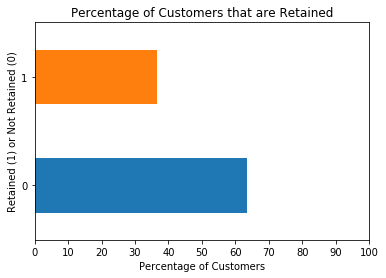

In [54]:
retained_counts.plot(kind='barh', title='Percentage of Customers that are Retained', xlim=(0, 100), 
                    xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], color=current_palette)
plt.xlabel('Percentage of Customers')
plt.ylabel('Retained (1) or Not Retained (0)')
plt.show()

In order to run correlations in conjunction with covariance matrices, a quick Pearson's R function is written.

In [55]:
def pearson_r(x, y):
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0, 1]

The list of features is called for reference, using pandas' '.info()' method.

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 24 columns):
avg_dist                       50000 non-null float64
avg_rating_by_driver           50000 non-null float64
avg_rating_of_driver           50000 non-null float64
avg_surge                      50000 non-null float64
surge_pct                      50000 non-null float64
trips_in_first_30_days         50000 non-null int64
ultimate_black_user            50000 non-null bool
weekday_pct                    50000 non-null float64
avg_rating_by_driver_isnull    50000 non-null bool
avg_rating_of_driver_isnull    50000 non-null bool
phone_isnull                   50000 non-null bool
retained                       50000 non-null int64
signup_year                    50000 non-null int64
signup_month                   50000 non-null int64
signup_day                     50000 non-null int64
last_trip_year                 50000 non-null int64
last_trip_month                50000 non-null int64

## 'avg_dist'

First, the average distance in miles per trip taken in the past 30 days after signup is visualized and its Pearson's correlation with the target variable is calculated. It can be seen that the majority of Ultimate trips are less than 20 miles.

Text(0, 0.5, 'Number of Customers')

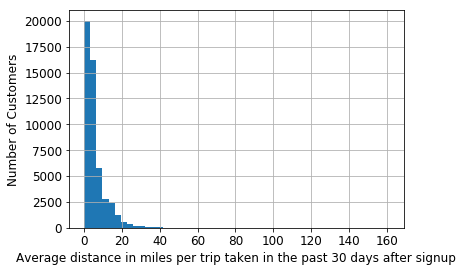

In [57]:
df['avg_dist'].hist(bins=50, grid=True, xlabelsize=12, ylabelsize=12)
plt.xlabel("Average distance in miles per trip taken in the past 30 days after signup", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)

In [58]:
r_avg_dist = pearson_r(df['avg_dist'], df['retained'])
r_avg_dist

-0.09027878047559727

In [59]:
cov_matrix_avg_dist = np.cov(df['avg_dist'], df['retained'])
cov_matrix_avg_dist

array([[32.57392054, -0.24823347],
       [-0.24823347,  0.2321022 ]])

## 'avg_rating_by_driver'

Second, the rider's average rating over all of their trips is visualized and its Pearson's correlation with the target variable is calculated. One can see that the majority of riders are rated above 4.5.

Text(0, 0.5, 'Number of Customers')

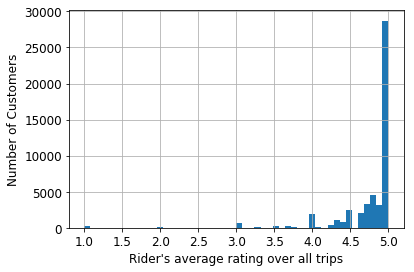

In [60]:
df['avg_rating_by_driver'].hist(bins=50, grid=True, xlabelsize=12, ylabelsize=12)
plt.xlabel("Rider's average rating over all trips", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)

In [61]:
r_avg_rating_by_driver = pearson_r(df['avg_rating_by_driver'], df['retained'])
r_avg_rating_by_driver

-0.02640000973444064

In [62]:
cov_matrix_avg_rating_by_driver = np.cov(df['avg_rating_by_driver'], df['retained'])
cov_matrix_avg_rating_by_driver

array([[ 0.19889288, -0.00567222],
       [-0.00567222,  0.2321022 ]])

## 'avg_rating_of_driver'

Third, the rider’s average rating of their drivers over all of their trips is visualized and its Pearson's correlation with the target variable is calculated. Again, the majority of drivers' ratings are above 4.5.

Text(0, 0.5, 'Number of Customers')

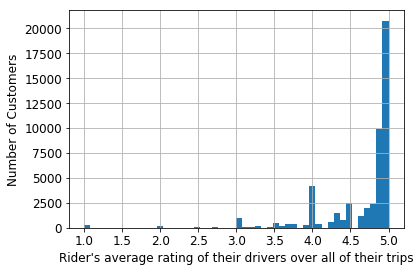

In [63]:
df['avg_rating_of_driver'].hist(bins=50, grid=True, xlabelsize=12, ylabelsize=12)
plt.xlabel("Rider's average rating of their drivers over all of their trips", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)

In [64]:
r_avg_rating_of_driver = pearson_r(df['avg_rating_of_driver'], df['retained'])
r_avg_rating_of_driver

-0.04016533225701913

In [65]:
cov_matrix_avg_rating_of_driver = np.cov(df['avg_rating_of_driver'], df['retained'])
cov_matrix_avg_rating_of_driver

array([[ 0.33131662, -0.01113814],
       [-0.01113814,  0.2321022 ]])

## 'avg_surge'

Fourth, the average surge multiplier over all of each user’s trips is visualized and its Pearson's correlation with the target variable is calculated. As one can see, the majority of trips have a surge multiplier less than 2.

Text(0, 0.5, 'Number of Customers')

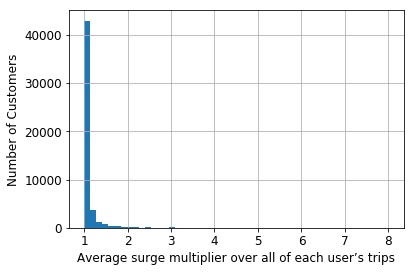

In [66]:
df['avg_surge'].hist(bins=50, grid=True, xlabelsize=12, ylabelsize=12)
plt.xlabel("Average surge multiplier over all of each user’s trips", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)

In [67]:
r_avg_surge = pearson_r(df['avg_surge'], df['retained'])
r_avg_surge

-0.0035673057509046646

In [68]:
cov_matrix_avg_surge = np.cov(df['avg_surge'], df['retained'])
cov_matrix_avg_surge

array([[ 0.0494333 , -0.00038211],
       [-0.00038211,  0.2321022 ]])

## 'surge_pct'

Fifth, the percentage of trips taken with a surge multiplier greater than one is visualized and its Pearson's correlation with the target variable is calculated. As can be seen, the majority of users had a surge multiplier greater than one with none of their trips.

Text(0, 0.5, 'Number of Customers')

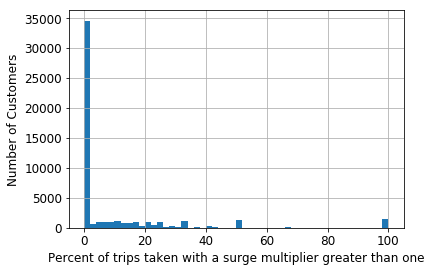

In [69]:
df['surge_pct'].hist(bins=50, grid=True, xlabelsize=12, ylabelsize=12)
plt.xlabel("Percent of trips taken with a surge multiplier greater than one", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)

In [70]:
r_surge_pct = pearson_r(df['surge_pct'], df['retained'])
r_surge_pct

0.010611553072836722

In [71]:
cov_matrix_surge_pct = np.cov(df['surge_pct'], df['retained'])
cov_matrix_surge_pct

array([[3.98354132e+02, 1.02035958e-01],
       [1.02035958e-01, 2.32102202e-01]])

## 'trips_in_first_30_days'

Next, the number of trips each user took in the first 30 days after signing up is visualized and its Pearson's correlation with the target variable is calculated. As can be seen, the majority of users took less than 10 trips in the first 30 days after signing up.

Text(0, 0.5, 'Number of Customers')

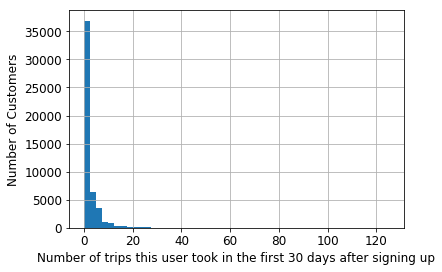

In [72]:
df['trips_in_first_30_days'].hist(bins=50, grid=True, xlabelsize=12, ylabelsize=12)
plt.xlabel("Number of trips this user took in the first 30 days after signing up", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)

In [73]:
r_trips_in_first_30_days = pearson_r(df['trips_in_first_30_days'], df['retained'])
r_trips_in_first_30_days

0.2147278984978567

In [74]:
cov_matrix_trips_in_first_30_days = np.cov(df['trips_in_first_30_days'], df['retained'])
cov_matrix_trips_in_first_30_days

array([[14.38445245,  0.39235101],
       [ 0.39235101,  0.2321022 ]])

## 'ultimate_black_user'

Next, the percentage of users who took an Ultimate Black trip is visualized and its Pearson's correlation with the target variable is calculated. As can be seen, only 37.7% of users took an Ultimate Black trip.

In [75]:
ultimate_black_user_counts = round(df['ultimate_black_user'].value_counts(normalize=True), 3)*100
ultimate_black_user_counts

False    62.3
True     37.7
Name: ultimate_black_user, dtype: float64

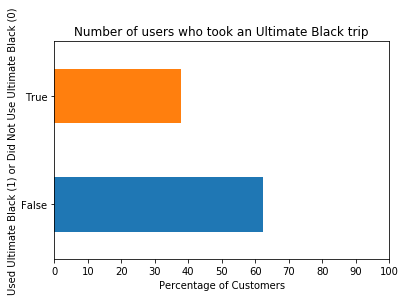

In [76]:
ultimate_black_user_counts.plot(kind='barh', title='Number of users who took an Ultimate Black trip', xlim=(0, 100), 
                    xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], color=current_palette)
plt.xlabel('Percentage of Customers')
plt.ylabel('Used Ultimate Black (1) or Did Not Use Ultimate Black (0)')
plt.show()

In [77]:
r_ultimate_black = pearson_r(df['ultimate_black_user'], df['retained'])
r_ultimate_black

0.21025875436996094

In [78]:
cov_matrix_trips_in_first_30_days = np.cov(df['ultimate_black_user'], df['retained'])
cov_matrix_trips_in_first_30_days

array([[0.23489537, 0.04909429],
       [0.04909429, 0.2321022 ]])

## 'weekday_pct'

Next, the percentage of each user's trips occurring during a weekday is visualized and its Pearson's correlation with the target variable is calculated. As can be seen below, a large number of users only take Ultimate trips on weekdays, while a significant number only take Ultimate trips on weekends. These are different types of users who could be further researched.

Text(0, 0.5, 'Number of Customers')

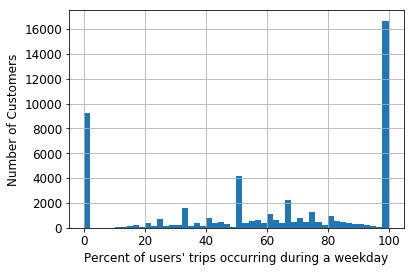

In [79]:
df['weekday_pct'].hist(bins=50, grid=True, xlabelsize=12, ylabelsize=12)
plt.xlabel("Percent of users' trips occurring during a weekday", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)

In [80]:
r_weekday_pct = pearson_r(df['weekday_pct'], df['retained'])
r_weekday_pct

0.02641321338426595

In [81]:
cov_matrix_weekday_pct = np.cov(df['weekday_pct'], df['retained'])
cov_matrix_weekday_pct

array([[1.37503789e+03, 4.71865477e-01],
       [4.71865477e-01, 2.32102202e-01]])

## 'signup_day'

Next, the day which users signed up for Ultimate is visualized and its Pearson's correlation with the target variable is calculated. The month or year is not investigated as all users signed up on January 2014. As can be seen below, there is no real pattern to the data in this feature.

Text(0, 0.5, 'Number of Customers')

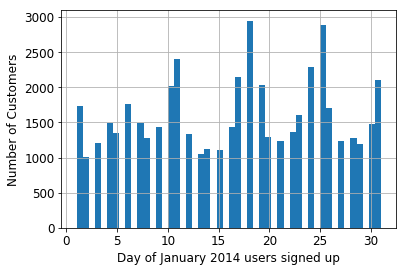

In [82]:
df['signup_day'].hist(bins=50, grid=True, xlabelsize=12, ylabelsize=12)
plt.xlabel("Day of January 2014 users signed up", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)

In [83]:
r_signup_day = pearson_r(df['signup_day'], df['retained'])
r_signup_day

-0.020572174912641284

In [84]:
cov_matrix_signup_day = np.cov(df['signup_day'], df['retained'])
cov_matrix_signup_day

array([[76.63637643, -0.08676355],
       [-0.08676355,  0.2321022 ]])

## 'last_trip_month'

Next, the month which users took their last trip with Ultimate is visualized and its Pearson's correlation with the target variable is calculated. The year is not looked at as all values are 2014. As can be seen, the month with the highest frequency is June.

Text(0, 0.5, 'Number of Customers')

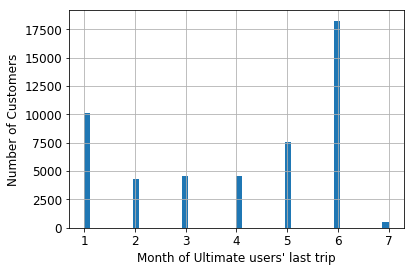

In [85]:
df['last_trip_month'].hist(bins=50, grid=True, xlabelsize=12, ylabelsize=12)
plt.xlabel("Month of Ultimate users' last trip", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)

In [86]:
r_last_trip_month = pearson_r(df['last_trip_month'], df['retained'])
r_last_trip_month

0.7581189008846555

In [87]:
cov_matrix_last_trip_month = np.cov(df['last_trip_month'], df['retained'])
cov_matrix_last_trip_month

array([[3.97156845, 0.72787697],
       [0.72787697, 0.2321022 ]])

## 'last_trip_day'

Next, the day of the month which users took their last trip with Ultimate is visualized and its Pearson's correlation with the target variable is calculated.

Text(0, 0.5, 'Number of Customers')

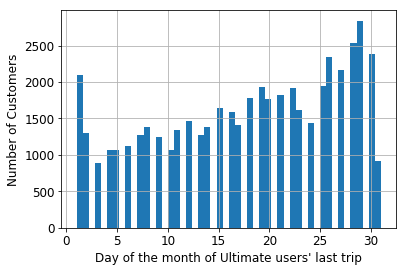

In [88]:
df['last_trip_day'].hist(bins=50, grid=True, xlabelsize=12, ylabelsize=12)
plt.xlabel("Day of the month of Ultimate users' last trip", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)

In [89]:
r_last_trip_day = pearson_r(df['last_trip_day'], df['retained'])
r_last_trip_day

0.19862897105165592

In [90]:
cov_matrix_last_trip_day = np.cov(df['last_trip_day'], df['retained'])
cov_matrix_last_trip_day

array([[80.10400959,  0.85646447],
       [ 0.85646447,  0.2321022 ]])

## 'city'

Next, which city Ultimate users signed up in is visualized and its Pearson's correlation with the target variable is calculated. As can be seen, 46.7% of users signed up in Winterfell, 33.1% of users signed up in Astapor, and 20.3% of users signed up in King's Landing. Therefore, customer recruitment efforts should be ramped up in Astapor and King's Landing.

In [91]:
df_no_binar = pd.read_csv('ultimate_no_binarization.csv')

In [92]:
city_counts = round(df_no_binar['city'].value_counts(normalize=True), 3)*100
city_counts

Winterfell        46.7
Astapor           33.1
King's Landing    20.3
Name: city, dtype: float64

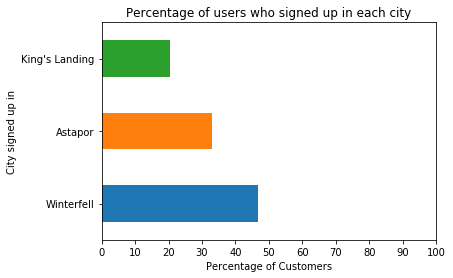

In [93]:
city_counts.plot(kind='barh', title='Percentage of users who signed up in each city', xlim=(0, 100), 
                    xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], color=current_palette)
plt.xlabel('Percentage of Customers')
plt.ylabel('City signed up in')
plt.show()

In [94]:
r_city_astapor = pearson_r(df['city_Astapor'], df['retained'])
r_city_astapor

-0.17937337646836576

In [95]:
cov_matrix_astapor = np.cov(df['city_Astapor'], df['retained'])
cov_matrix_astapor

array([[ 0.22133516, -0.04065583],
       [-0.04065583,  0.2321022 ]])

Next, whether users signed up in the city of King's Landing or not is visualized and its Pearson's correlation with the target variable is calculated. First, the name of the feature is renamed in Excel to drop the problematic apostrophe.

In [96]:
df.to_csv('ultimate.csv')

In [97]:
del df

Here, the variable 'city_King's Landing' is changed to 'city_Kings_Landing' in Excel.

In [98]:
df = pd.read_csv('ultimate.csv')

In [99]:
r_Kings_Landing = pearson_r(df['city_Kings_Landing'], df['retained'])
r_Kings_Landing

0.2682716034626618

In [100]:
cov_matrix_Kings_Landing = np.cov(df['city_Kings_Landing'], df['retained'])
cov_matrix_Kings_Landing

array([[0.16155647, 0.05194892],
       [0.05194892, 0.2321022 ]])

In [101]:
r_Winterfell = pearson_r(df['city_Winterfell'], df['retained'])
r_Winterfell

-0.0469854030320964

In [102]:
cov_matrix_Winterfell = np.cov(df['city_Winterfell'], df['retained'])
cov_matrix_Winterfell

array([[ 0.24889742, -0.01129309],
       [-0.01129309,  0.2321022 ]])

## 'phone'

Next, users' primary device is visualized and its Pearson's correlation with the target variable is calculated.

In [103]:
phone_counts = round(df_no_binar['phone'].value_counts(normalize=True), 3)*100
phone_counts

iPhone            69.2
Android           30.0
unknown_device     0.8
Name: phone, dtype: float64

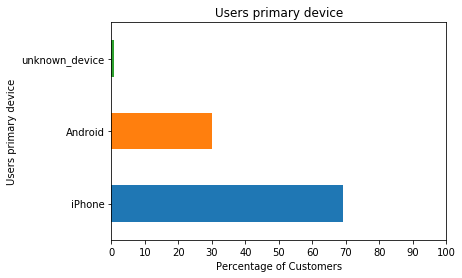

In [104]:
phone_counts.plot(kind='barh', title='Users primary device', xlim=(0, 100), 
                    xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], color=current_palette)
plt.xlabel('Percentage of Customers')
plt.ylabel('Users primary device')
plt.show()

In [105]:
r_android = pearson_r(df['phone_Android'], df['retained'])
r_android

-0.23173050316390426

In [106]:
cov_matrix_android = np.cov(df['phone_Android'], df['retained'])
cov_matrix_android

array([[ 0.21018001, -0.05118215],
       [-0.05118215,  0.2321022 ]])

In [107]:
r_iphone = pearson_r(df['phone_iPhone'], df['retained'])
r_iphone

0.23139089276373617

In [108]:
cov_matrix_iphone = np.cov(df['phone_iPhone'], df['retained'])
cov_matrix_iphone

array([[0.21327838, 0.05148246],
       [0.05148246, 0.2321022 ]])

In [109]:
r_unknown_device = pearson_r(df['phone_unknown_device'], df['retained'])
r_unknown_device

-0.00703217858872667

In [110]:
cov_matrix_unknown_device = np.cov(df['phone_unknown_device'], df['retained'])
cov_matrix_unknown_device

array([[ 0.00785743, -0.00030031],
       [-0.00030031,  0.2321022 ]])

In [111]:
df.head(1)

,Unnamed: 0,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,avg_rating_by_driver_isnull,...,signup_day,last_trip_year,last_trip_month,last_trip_day,city_Astapor,city_Kings_Landing,city_Winterfell,phone_Android,phone_iPhone,phone_unknown_device
0,0,3.67,5.0,4.7,1.1,15.4,4,True,46.2,False,...,25,2014,6,17,0,1,0,0,1,0


The 'unnamed' feature that was an artifact of the editing of the King's Landing feature name in Excel is dropped from the DataFrame as it will introduce noise into the machine learning model.

In [112]:
df = df.drop(columns = 'Unnamed: 0')

## Summary of EDA

Some important correlations between specific features in the feature set and the 'retained' target variable should be pointed out. 

The number of Ultimate trips a user took in the first 30 days after signing up has a weakly positive relationship (0.22) with whether they are retained customers. This suggests that Ultimate try and find ways to incentivize more trips taken during that 30 day window.

Whether or not Ultimate users ever took an Ultimate Black trip has a weakly positive relationship (0.21) with whether they are retained customers. This suggests that Ultimate try and find ways to incentivize Ultimate Black trips among new users.

The month of the last trip an Ultimate user took has a very strong positive relationsip (0.76) with whether they are retained customers. This is clearly an effect of defining a retained customer as one who has taken an Ultimate trip in the last month.

A customer signing up for an Ultimate subscription in the city of Astapor has a weakly negative relationship (-0.18) with whether they are retained customers. This finding suggests that more outreach needs to be taken with Astapor-based customers to increase their retention rates. It also warrants further research into whether there is something specific to rides taken from Astapor that are of lower quality, whether it has to do with drivers, cars, or a quirk in the app that occurs only in Astapor.

A customer signing up for an Ultimate subscription in the city of King's Landing has a moderately positive  relationship (0.27) with whether they are retained customers. This finding warrants further research into whether there is something about rides taken from King's Landing that is particularly positive, and that could possibly be used to improve the experience of Astapor-based riders.

A customer having his or her primary device being an Android phone has a weakly negative relationship (-0.23) with whether they are retained customers. This warrants UX research into the Android version of the Ultimate app that may be reducing the quality of Android-based customers' experience with Ultimate.

A customer having his or her primary device being an iPhone has a weakly positive relationship (0.23) with whether they are retained customers. This warrants UX research into the iPhone version of the Ultimate app that may be increasing the quality of iPhone-based customers' experience with Ultimate, and whether there are qualities of the iPhone Ultimate app that could be carried over to the Android version.

## Hypothesis Testing

The Pearson's correlations suggest hypothesis tests that can determine whether the retention rates between Astapor and King's Landing Ultimate customers is due to chance, and whether retention rates between Android and iPhone Ultimate customers is due to chance.

In [113]:
import scipy.stats
import statsmodels
from numpy.random import seed

In [114]:
astapor = df[df.city_Astapor == 1]
len(astapor)

16534

In [115]:
kings_landing = df[df.city_Kings_Landing == 1]
len(kings_landing)

10130

For the Astapor group, the necessary statistics for running hypothesis tests are assigned to objects below. First, the N, or sample size, is assigned to 'n_astapor'.

In [116]:
n_astapor = len(astapor)
n_astapor

16534

Second, the mean value of 'retained' for Astapor customers is computed.

In [117]:
astapor_retained = np.mean(astapor['retained'])
astapor_retained

0.24325632030966493

The standard deviation of 'retained' for Astapor customers is assigned to 'astapor_std', for use in the t-test function that will be run below.

In [118]:
astapor_std = np.std(astapor['retained'])
astapor_std

0.42904857876366387

For the King's Landing group, the necessary statistics for running hypothesis tests are assigned to objects below. First, the N, or sample size is assigned to 'n_kings_landing'.

In [119]:
n_kings_landing = len(kings_landing)
n_kings_landing

10130

Second, the mean value of 'retained' for King's Landing customers is computed.

In [120]:
kings_landing_retained = np.mean(kings_landing['retained'])
kings_landing_retained

0.6226061204343534

The standard deviation of 'retained' for King's Landing customers is assigned to 'kings_landing_std', for use in the t-test function that will be run below.

In [121]:
kings_landing_std = np.std(kings_landing['retained'])
kings_landing_std

0.48473471015804853

The t-test is run using the mean and standard deviation of the 'retained' target feature, along with the sample size, of Astapor and King's Landing customers. The t-score is approximately 66.6 and the p-value is 0.0.

In [122]:
scipy.stats.ttest_ind_from_stats(astapor_retained, astapor_std, n_astapor, 
                                 kings_landing_retained, kings_landing_std, n_kings_landing)

Ttest_indResult(statistic=-66.66230895487753, pvalue=0.0)

The first null hypothesis is rejected. Although causality and the identification of confounding variables is outside the scope of this analysis, one cannot say that the difference in customer retention rates seen in Astapor and King's Landing customers is due to random chance. This definitely warrants further research.

In [123]:
android = df[df.phone_Android == 1]
len(android)

15022

In [124]:
iphone = df[df.phone_iPhone == 1]
len(iphone)

34582

For the Android group, the necessary statistics for running hypothesis tests are assigned to objects below. First, the N, or sample size, is assigned to 'n_android'.

In [125]:
n_android = len(android)
n_android

15022

Second, the mean value of 'retained' for Android customers is computed.

In [126]:
android_retained = np.mean(android['retained'])
android_retained

0.19584609239781653

The standard deviation of 'retained' for Android customers is assigned to 'android_std', for use in the t-test function that will be run below.

In [127]:
android_std = np.std(android['retained'])
android_std

0.3968506022300144

For the iPhone group, the necessary statistics for running hypothesis tests are assigned to objects below. First, the N, or sample size is assigned to 'n_iphone'.

In [128]:
n_iphone = len(iphone)
n_iphone

34582

Second, the mean value of 'retained' for iPhone customers is computed.

In [129]:
iphone_retained = np.mean(iphone['retained'])
iphone_retained

0.44063385576311376

The standard deviation of 'retained' for iPhone customers is assigned to 'iphone_std', for use in the t-test function that will be run below.

In [130]:
iphone_std = np.std(iphone['retained'])
iphone_std

0.49646315162203847

The t-test is run using the mean and standard deviation of the 'retained' target feature, along with the sample size, of Android and iPhone customers. The t-score is approximately 53.5 and the p-value is 0.0.

In [131]:
scipy.stats.ttest_ind_from_stats(android_retained, android_std, n_android, 
                                 iphone_retained, iphone_std, n_iphone)

Ttest_indResult(statistic=-53.46568328360137, pvalue=0.0)

The second null hypothesis is rejected. Although causality and the identification of confounding variables is again outside the scope of this analysis, one cannot say that the difference in customer retention rates seen in Android and iPhone customers is due to random chance. This definitely warrants further research.

## Machine Learning: Optimizing the Classification Algorithm

First, the 'retained' target variable is examined to determine if the two classes 'retained' and 'not retained' are balanced or imbalanced.

In [132]:
df['retained'].value_counts()

0    31690
1    18310
Name: retained, dtype: int64

In [133]:
df['retained'].value_counts(normalize=True)

0    0.6338
1    0.3662
Name: retained, dtype: float64

Only 36% of users were retained, so the classes are imbalanced. Therefore, a train/test split is first created and then a class balancing procedure is carried out.

One other step that needs to take place is to drop the feature 'last_trip_month'. This feature will cause data leakage, as it contains information on the month of the last trip. The target variable is defined by customers taking the last trip within the last 30 days, or the month of the last trip. Therefore, the 'last_trip_month' feature contains the same information as the target variable, causing data leakage. Therefore, it is dropped from the DataFrame in the next cell.

In [134]:
df = df.drop(columns = 'last_trip_month')

In [135]:
y = df['retained']

In [136]:
target_names = ['retained']
X = df[[cn for cn in df.columns if cn not in target_names]]

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

First, the training data is concatenated back together.

In [138]:
X = pd.concat([X_train, y_train], axis=1)

Then, the minority and majority classes are separated.

In [139]:
not_retained = X[X.retained == 0]
retained = X[X.retained == 1]

Then, the minority class (i.e., retained) is upsampled.

In [140]:
from sklearn.utils import resample

In [141]:
retained_upsampled = resample(retained,
                          replace=True, # sample with replacement
                          n_samples=len(not_retained), # match number in majority class
                          random_state=27) # reproducible results

Then, the majority and upsampled minority classes are combined.

In [142]:
upsampled = pd.concat([not_retained, retained_upsampled])

The new class counts are checked.

In [143]:
upsampled.retained.value_counts()

1    25352
0    25352
Name: retained, dtype: int64

The 'y_train' target and 'X_train' feature set is then re-defined.

In [144]:
y_train = upsampled.retained

In [145]:
X_train = upsampled.drop('retained', axis=1)

In [146]:
lr_1 = linear_model.LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [147]:
lr_pred_1 = lr_1.predict(X_test)
lr_pred_1[0:35]

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1])

In [148]:
accuracy_score(y_test, lr_pred_1)

0.7141

In [149]:
print(confusion_matrix(y_test, lr_pred_1))

[[4659 1679]
 [1180 2482]]


In [150]:
print(classification_report(y_test, lr_pred_1))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      6338
           1       0.60      0.68      0.63      3662

   micro avg       0.71      0.71      0.71     10000
   macro avg       0.70      0.71      0.70     10000
weighted avg       0.72      0.71      0.72     10000



In [151]:
lr_2 = linear_model.LogisticRegression(penalty='l2', C=0.01, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [152]:
lr_pred_2 = lr_2.predict(X_test)
lr_pred_2[0:35]

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1])

In [153]:
accuracy_score(y_test, lr_pred_2)

0.7169

In [154]:
print(confusion_matrix(y_test, lr_pred_2))

[[4659 1679]
 [1152 2510]]


In [155]:
print(classification_report(y_test, lr_pred_2))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      6338
           1       0.60      0.69      0.64      3662

   micro avg       0.72      0.72      0.72     10000
   macro avg       0.70      0.71      0.70     10000
weighted avg       0.73      0.72      0.72     10000



In [156]:
lr_3 = linear_model.LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [157]:
lr_pred_3 = lr_3.predict(X_test)
lr_pred_3[0:35]

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1])

In [158]:
accuracy_score(y_test, lr_pred_3)

0.7173

In [159]:
print(confusion_matrix(y_test, lr_pred_3))

[[4659 1679]
 [1148 2514]]


In [160]:
print(classification_report(y_test, lr_pred_3))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      6338
           1       0.60      0.69      0.64      3662

   micro avg       0.72      0.72      0.72     10000
   macro avg       0.70      0.71      0.70     10000
weighted avg       0.73      0.72      0.72     10000



In [161]:
lr_4 = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [162]:
lr_pred_4 = lr_4.predict(X_test)
lr_pred_4[0:35]

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1])

In [163]:
accuracy_score(y_test, lr_pred_4)

0.7173

In [164]:
print(confusion_matrix(y_test, lr_pred_4))

[[4658 1680]
 [1147 2515]]


In [165]:
print(classification_report(y_test, lr_pred_4))

              precision    recall  f1-score   support

           0       0.80      0.73      0.77      6338
           1       0.60      0.69      0.64      3662

   micro avg       0.72      0.72      0.72     10000
   macro avg       0.70      0.71      0.70     10000
weighted avg       0.73      0.72      0.72     10000



In [166]:
lr_5 = linear_model.LogisticRegression(penalty='l2', C=10.0, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [167]:
lr_pred_5 = lr_5.predict(X_test)
lr_pred_5[0:35]

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1])

In [168]:
accuracy_score(y_test, lr_pred_5)

0.7169

In [169]:
print(confusion_matrix(y_test, lr_pred_5))

[[4655 1683]
 [1148 2514]]


In [170]:
print(classification_report(y_test, lr_pred_5))

              precision    recall  f1-score   support

           0       0.80      0.73      0.77      6338
           1       0.60      0.69      0.64      3662

   micro avg       0.72      0.72      0.72     10000
   macro avg       0.70      0.71      0.70     10000
weighted avg       0.73      0.72      0.72     10000



In [171]:
lr_6 = linear_model.LogisticRegression(penalty='l2', C=100.0, solver='lbfgs', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [172]:
lr_pred_6 = lr_6.predict(X_test)
lr_pred_6[0:35]

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1])

In [173]:
accuracy_score(y_test, lr_pred_6)

0.7177

In [174]:
confusion_matrix(y_test, lr_pred_6)

array([[4663, 1675],
       [1148, 2514]])

In [175]:
print(classification_report(y_test, lr_pred_6))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      6338
           1       0.60      0.69      0.64      3662

   micro avg       0.72      0.72      0.72     10000
   macro avg       0.70      0.71      0.70     10000
weighted avg       0.73      0.72      0.72     10000



In [176]:
lr_7 = linear_model.LogisticRegression(penalty='l1', C=0.001, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [177]:
lr_pred_7 = lr_7.predict(X_test)
lr_pred_7[0:35]

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1])

In [178]:
accuracy_score(y_test, lr_pred_7)

0.6926

In [179]:
confusion_matrix(y_test, lr_pred_7)

array([[4538, 1800],
       [1274, 2388]])

In [180]:
print(classification_report(y_test, lr_pred_7))

              precision    recall  f1-score   support

           0       0.78      0.72      0.75      6338
           1       0.57      0.65      0.61      3662

   micro avg       0.69      0.69      0.69     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.70      0.69      0.70     10000



In [181]:
lr_8 = linear_model.LogisticRegression(penalty='l1', C=0.01, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [182]:
lr_pred_8 = lr_8.predict(X_test)
lr_pred_8[0:35]

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1])

In [183]:
accuracy_score(y_test, lr_pred_8)

0.7057

In [184]:
confusion_matrix(y_test, lr_pred_8)

array([[4609, 1729],
       [1214, 2448]])

In [185]:
print(classification_report(y_test, lr_pred_8))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76      6338
           1       0.59      0.67      0.62      3662

   micro avg       0.71      0.71      0.71     10000
   macro avg       0.69      0.70      0.69     10000
weighted avg       0.72      0.71      0.71     10000



In [186]:
lr_9 = linear_model.LogisticRegression(penalty='l1', C=0.1, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [187]:
lr_pred_9 = lr_9.predict(X_test)
lr_pred_9[0:35]

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1])

In [188]:
accuracy_score(y_test, lr_pred_9)

0.7079

In [189]:
confusion_matrix(y_test, lr_pred_9)

array([[4622, 1716],
       [1205, 2457]])

In [190]:
print(classification_report(y_test, lr_pred_9))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76      6338
           1       0.59      0.67      0.63      3662

   micro avg       0.71      0.71      0.71     10000
   macro avg       0.69      0.70      0.69     10000
weighted avg       0.72      0.71      0.71     10000



In [191]:
lr_10 = linear_model.LogisticRegression(penalty='l1', C=1.0, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [192]:
lr_pred_10 = lr_10.predict(X_test)
lr_pred_10[0:35]

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1])

In [193]:
accuracy_score(y_test, lr_pred_10)

0.7077

In [194]:
confusion_matrix(y_test, lr_pred_10)

array([[4618, 1720],
       [1203, 2459]])

In [195]:
print(classification_report(y_test, lr_pred_10))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76      6338
           1       0.59      0.67      0.63      3662

   micro avg       0.71      0.71      0.71     10000
   macro avg       0.69      0.70      0.69     10000
weighted avg       0.72      0.71      0.71     10000



In [196]:
lr_11 = linear_model.LogisticRegression(penalty='l1', C=10, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [197]:
lr_pred_11 = lr_11.predict(X_test)
lr_pred_11[0:35]

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1])

In [198]:
accuracy_score(y_test, lr_pred_11)

0.7082

In [199]:
confusion_matrix(y_test, lr_pred_11)

array([[4624, 1714],
       [1204, 2458]])

In [200]:
print(classification_report(y_test, lr_pred_11))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76      6338
           1       0.59      0.67      0.63      3662

   micro avg       0.71      0.71      0.71     10000
   macro avg       0.69      0.70      0.69     10000
weighted avg       0.72      0.71      0.71     10000



In [201]:
lr_12 = linear_model.LogisticRegression(penalty='l1', C=100, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [202]:
lr_pred_12 = lr_12.predict(X_test)
lr_pred_12[0:35]

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1])

In [203]:
accuracy_score(y_test, lr_pred_12)

0.7078

In [204]:
confusion_matrix(y_test, lr_pred_12)

array([[4620, 1718],
       [1204, 2458]])

In [205]:
print(classification_report(y_test, lr_pred_12))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76      6338
           1       0.59      0.67      0.63      3662

   micro avg       0.71      0.71      0.71     10000
   macro avg       0.69      0.70      0.69     10000
weighted avg       0.72      0.71      0.71     10000



In [206]:
rfc_1 = RandomForestClassifier().fit(X_train, y_train)

/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [207]:
rfc_pred_1 = rfc_1.predict(X_test)

In [208]:
accuracy_score(y_test, rfc_pred_1)

0.7891

In [209]:
confusion_matrix(y_test, rfc_pred_1)

array([[5588,  750],
       [1359, 2303]])

In [210]:
print(classification_report(y_test, rfc_pred_1))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      6338
           1       0.75      0.63      0.69      3662

   micro avg       0.79      0.79      0.79     10000
   macro avg       0.78      0.76      0.76     10000
weighted avg       0.79      0.79      0.78     10000



In [211]:
rfc_2 = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [212]:
rfc_pred_2 = rfc_2.predict(X_test)

In [213]:
accuracy_score(y_test, rfc_pred_2)

0.8054

In [214]:
confusion_matrix(y_test, rfc_pred_2)

array([[5547,  791],
       [1155, 2507]])

In [215]:
print(classification_report(y_test, rfc_pred_2))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      6338
           1       0.76      0.68      0.72      3662

   micro avg       0.81      0.81      0.81     10000
   macro avg       0.79      0.78      0.79     10000
weighted avg       0.80      0.81      0.80     10000



## Scaled Data

Scaled data is experimented with next to see if the models perform differently. The classes are balanced again, as before.

In [217]:
scaler = MinMaxScaler()

In [218]:
scaler.fit(df)

/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [219]:
df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)

In [220]:
df_scaled.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,avg_rating_by_driver_isnull,avg_rating_of_driver_isnull,...,signup_month,signup_day,last_trip_year,last_trip_day,city_Astapor,city_Kings_Landing,city_Winterfell,phone_Android,phone_iPhone,phone_unknown_device
0,0.022801,1.000,0.925,0.014286,0.154,0.032,1.0,0.462,0.0,0.0,...,0.0,0.800000,0.0,0.533333,0.0,1.0,0.0,0.0,1.0,0.0
1,0.051317,1.000,1.000,0.000000,0.000,0.000,0.0,0.500,0.0,0.0,...,0.0,0.933333,0.0,0.133333,1.0,0.0,0.0,1.0,0.0,0.0
2,0.004784,1.000,0.825,0.000000,0.000,0.024,0.0,1.000,0.0,0.0,...,0.0,0.166667,0.0,0.200000,1.0,0.0,0.0,0.0,1.0,0.0
3,0.014662,0.975,0.900,0.020000,0.200,0.072,1.0,0.800,0.0,0.0,...,0.0,0.300000,0.0,0.933333,0.0,1.0,0.0,0.0,1.0,0.0
4,0.019446,0.975,0.850,0.027143,0.118,0.112,0.0,0.824,0.0,0.0,...,0.0,0.866667,0.0,0.466667,0.0,0.0,1.0,1.0,0.0,0.0


In [221]:
y = df_scaled['retained']

In [222]:
target_names = ['retained']
X = df_scaled[[cn for cn in df_scaled.columns if cn not in target_names]]

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

First, the training data is concatenated back together.

In [224]:
X = pd.concat([X_train, y_train], axis=1)

Then, the minority and majority classes are separated.

In [225]:
not_retained = X[X.retained == 0]
retained = X[X.retained == 1]

Then, the minority class (i.e., retained) is upsampled.

In [226]:
retained_upsampled = resample(retained,
                          replace=True, # sample with replacement
                          n_samples=len(not_retained), # match number in majority class
                          random_state=27) # reproducible results

Then, the majority and upsampled minority classes are combined.

In [227]:
upsampled = pd.concat([not_retained, retained_upsampled])

The new class counts are checked.

In [228]:
upsampled.retained.value_counts()

1.0    25352
0.0    25352
Name: retained, dtype: int64

The 'y_train' target and 'X_train' feature set is then re-defined.

In [229]:
y_train = upsampled.retained

In [230]:
X_train = upsampled.drop('retained', axis=1)

In [231]:
lr_13 = linear_model.LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [232]:
lr_pred_13 = lr_13.predict(X_test)
lr_pred_13[0:35]

array([0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1.])

In [233]:
accuracy_score(y_test, lr_pred_13)

0.7048

In [234]:
confusion_matrix(y_test, lr_pred_13)

array([[4512, 1826],
       [1126, 2536]])

In [235]:
print(classification_report(y_test, lr_pred_13))

              precision    recall  f1-score   support

         0.0       0.80      0.71      0.75      6338
         1.0       0.58      0.69      0.63      3662

   micro avg       0.70      0.70      0.70     10000
   macro avg       0.69      0.70      0.69     10000
weighted avg       0.72      0.70      0.71     10000



In [236]:
lr_14 = linear_model.LogisticRegression(penalty='l2', C=0.01, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [237]:
lr_pred_14 = lr_14.predict(X_test)
lr_pred_14[0:35]

array([0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1.])

In [238]:
accuracy_score(y_test, lr_pred_14)

0.7111

In [239]:
print(confusion_matrix(y_test, lr_pred_14))

[[4560 1778]
 [1111 2551]]


In [240]:
print(classification_report(y_test, lr_pred_14))

              precision    recall  f1-score   support

         0.0       0.80      0.72      0.76      6338
         1.0       0.59      0.70      0.64      3662

   micro avg       0.71      0.71      0.71     10000
   macro avg       0.70      0.71      0.70     10000
weighted avg       0.73      0.71      0.72     10000



In [241]:
lr_15 = linear_model.LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [242]:
lr_pred_15 = lr_15.predict(X_test)
lr_pred_15[0:35]

array([0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1.])

In [243]:
accuracy_score(y_test, lr_pred_15)

0.7163

In [244]:
print(confusion_matrix(y_test, lr_pred_15))

[[4593 1745]
 [1092 2570]]


In [245]:
print(classification_report(y_test, lr_pred_15))

              precision    recall  f1-score   support

         0.0       0.81      0.72      0.76      6338
         1.0       0.60      0.70      0.64      3662

   micro avg       0.72      0.72      0.72     10000
   macro avg       0.70      0.71      0.70     10000
weighted avg       0.73      0.72      0.72     10000



In [246]:
lr_16 = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [247]:
lr_pred_16 = lr_16.predict(X_test)
lr_pred_16[0:35]

array([0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1.])

In [248]:
accuracy_score(y_test, lr_pred_16)

0.7176

In [249]:
print(confusion_matrix(y_test, lr_pred_16))

[[4640 1698]
 [1126 2536]]


In [250]:
print(classification_report(y_test, lr_pred_16))

              precision    recall  f1-score   support

         0.0       0.80      0.73      0.77      6338
         1.0       0.60      0.69      0.64      3662

   micro avg       0.72      0.72      0.72     10000
   macro avg       0.70      0.71      0.70     10000
weighted avg       0.73      0.72      0.72     10000



In [251]:
lr_17 = linear_model.LogisticRegression(penalty='l2', C=10.0, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [252]:
lr_pred_17 = lr_17.predict(X_test)
lr_pred_17[0:35]

array([0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1.])

In [253]:
accuracy_score(y_test, lr_pred_17)

0.7179

In [254]:
print(confusion_matrix(y_test, lr_pred_17))

[[4652 1686]
 [1135 2527]]


In [255]:
print(classification_report(y_test, lr_pred_17))

              precision    recall  f1-score   support

         0.0       0.80      0.73      0.77      6338
         1.0       0.60      0.69      0.64      3662

   micro avg       0.72      0.72      0.72     10000
   macro avg       0.70      0.71      0.70     10000
weighted avg       0.73      0.72      0.72     10000



In [256]:
lr_18 = linear_model.LogisticRegression(penalty='l2', C=100.0, solver='lbfgs', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [257]:
lr_pred_18 = lr_18.predict(X_test)
lr_pred_18[0:35]

array([0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1.])

In [258]:
accuracy_score(y_test, lr_pred_18)

0.7184

In [259]:
confusion_matrix(y_test, lr_pred_18)

array([[4654, 1684],
       [1132, 2530]])

In [260]:
print(classification_report(y_test, lr_pred_18))

              precision    recall  f1-score   support

         0.0       0.80      0.73      0.77      6338
         1.0       0.60      0.69      0.64      3662

   micro avg       0.72      0.72      0.72     10000
   macro avg       0.70      0.71      0.71     10000
weighted avg       0.73      0.72      0.72     10000



In [261]:
lr_19 = linear_model.LogisticRegression(penalty='l1', C=0.001, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [262]:
lr_pred_19 = lr_19.predict(X_test)
lr_pred_19[0:35]

array([0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0.])

In [263]:
accuracy_score(y_test, lr_pred_19)

0.7057

In [264]:
confusion_matrix(y_test, lr_pred_19)

array([[4627, 1711],
       [1232, 2430]])

In [265]:
print(classification_report(y_test, lr_pred_19))

              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76      6338
         1.0       0.59      0.66      0.62      3662

   micro avg       0.71      0.71      0.71     10000
   macro avg       0.69      0.70      0.69     10000
weighted avg       0.72      0.71      0.71     10000



In [266]:
lr_20 = linear_model.LogisticRegression(penalty='l1', C=0.01, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [267]:
lr_pred_20 = lr_20.predict(X_test)
lr_pred_20[0:35]

array([0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1.])

In [268]:
accuracy_score(y_test, lr_pred_20)

0.7064

In [269]:
confusion_matrix(y_test, lr_pred_20)

array([[4515, 1823],
       [1113, 2549]])

In [270]:
print(classification_report(y_test, lr_pred_20))

              precision    recall  f1-score   support

         0.0       0.80      0.71      0.75      6338
         1.0       0.58      0.70      0.63      3662

   micro avg       0.71      0.71      0.71     10000
   macro avg       0.69      0.70      0.69     10000
weighted avg       0.72      0.71      0.71     10000



In [271]:
lr_21 = linear_model.LogisticRegression(penalty='l1', C=0.1, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [272]:
lr_pred_21 = lr_21.predict(X_test)
lr_pred_21[0:35]

array([0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1.])

In [273]:
accuracy_score(y_test, lr_pred_21)

0.7187

In [274]:
confusion_matrix(y_test, lr_pred_21)

array([[4658, 1680],
       [1133, 2529]])

In [275]:
print(classification_report(y_test, lr_pred_21))

              precision    recall  f1-score   support

         0.0       0.80      0.73      0.77      6338
         1.0       0.60      0.69      0.64      3662

   micro avg       0.72      0.72      0.72     10000
   macro avg       0.70      0.71      0.71     10000
weighted avg       0.73      0.72      0.72     10000



In [276]:
lr_22 = linear_model.LogisticRegression(penalty='l1', C=1.0, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [277]:
lr_pred_22 = lr_22.predict(X_test)
lr_pred_22[0:35]

array([0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1.])

In [278]:
accuracy_score(y_test, lr_pred_22)

0.7177

In [279]:
confusion_matrix(y_test, lr_pred_22)

array([[4645, 1693],
       [1130, 2532]])

In [280]:
print(classification_report(y_test, lr_pred_22))

              precision    recall  f1-score   support

         0.0       0.80      0.73      0.77      6338
         1.0       0.60      0.69      0.64      3662

   micro avg       0.72      0.72      0.72     10000
   macro avg       0.70      0.71      0.70     10000
weighted avg       0.73      0.72      0.72     10000



In [281]:
lr_23 = linear_model.LogisticRegression(penalty='l1', C=10, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [282]:
lr_pred_23 = lr_23.predict(X_test)
lr_pred_23[0:35]

array([0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1.])

In [283]:
accuracy_score(y_test, lr_pred_23)

0.7187

In [284]:
confusion_matrix(y_test, lr_pred_23)

array([[4662, 1676],
       [1137, 2525]])

In [285]:
print(classification_report(y_test, lr_pred_23))

              precision    recall  f1-score   support

         0.0       0.80      0.74      0.77      6338
         1.0       0.60      0.69      0.64      3662

   micro avg       0.72      0.72      0.72     10000
   macro avg       0.70      0.71      0.71     10000
weighted avg       0.73      0.72      0.72     10000



In [286]:
lr_24 = linear_model.LogisticRegression(penalty='l1', C=100, solver='saga', max_iter=12000, tol=0.001).fit(X_train, y_train)

In [287]:
lr_pred_24 = lr_24.predict(X_test)
lr_pred_24[0:35]

array([0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1.])

In [288]:
accuracy_score(y_test, lr_pred_24)

0.7186

In [289]:
confusion_matrix(y_test, lr_pred_24)

array([[4661, 1677],
       [1137, 2525]])

In [290]:
print(classification_report(y_test, lr_pred_24))

              precision    recall  f1-score   support

         0.0       0.80      0.74      0.77      6338
         1.0       0.60      0.69      0.64      3662

   micro avg       0.72      0.72      0.72     10000
   macro avg       0.70      0.71      0.71     10000
weighted avg       0.73      0.72      0.72     10000



In [291]:
rfc_1s = RandomForestClassifier().fit(X_train, y_train)

/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [292]:
rfc_pred_1s = rfc_1s.predict(X_test)

In [293]:
accuracy_score(y_test, rfc_pred_1s)

0.7828

In [294]:
confusion_matrix(y_test, rfc_pred_1s)

array([[5567,  771],
       [1401, 2261]])

In [295]:
print(classification_report(y_test, rfc_pred_1s))

              precision    recall  f1-score   support

         0.0       0.80      0.88      0.84      6338
         1.0       0.75      0.62      0.68      3662

   micro avg       0.78      0.78      0.78     10000
   macro avg       0.77      0.75      0.76     10000
weighted avg       0.78      0.78      0.78     10000



In [296]:
rfc_2s = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [297]:
rfc_pred_2s = rfc_2s.predict(X_test)

In [298]:
accuracy_score(y_test, rfc_pred_2s)

0.8054

In [299]:
confusion_matrix(y_test, rfc_pred_2s)

array([[5544,  794],
       [1152, 2510]])

In [300]:
print(classification_report(y_test, rfc_pred_2s))

              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85      6338
         1.0       0.76      0.69      0.72      3662

   micro avg       0.81      0.81      0.81     10000
   macro avg       0.79      0.78      0.79     10000
weighted avg       0.80      0.81      0.80     10000



As can be seen in the table below, the top performing Logistic Regression classification algorithm uses scaled data, the 'saga' solver, the L1 penalty, and a regularization 'C' parameter of 0.1 ('lr_21'). The top performing algorithm overall is the Random Forest classifier using unscaled data and 100 estimators. However, the Random Forest algorithm does not have regression coefficients that can be used to highlight the features that are most predictive of customer retention.

In [302]:
hp_tuning_table = pd.read_excel('Ultimate_HP_tuning_table.xlsx')
hp_tuning_table

,Unnamed: 0,LR_#,Accuracy_Score,Precision_Not_Retained,Precision_Retained,Precision_Average,Recall_Not_Retained,Recall_Retained,Recall_Average,F1_Score_Not_Retained,F1_Score_Retained,F1_Score_Average,Support_Not_Retained,Support_Retained,Support_Total
0,"RF, unscaled, 100 n_estimators","rfc_2, 100 estimators",0.8054,0.83,0.76,0.80,0.88,0.68,0.81,0.85,0.72,0.80,6338,3662,10000
1,"RF, scaled, 100 n_estimators","rfc_2s, 100 estimators",0.8054,0.83,0.76,0.80,0.87,0.69,0.81,0.85,0.72,0.80,6338,3662,10000
2,"RF, unscaled, 10 n_estimators","rfc_1, 10 estimators",0.7891,0.80,0.75,0.79,0.88,0.63,0.79,0.84,0.69,0.78,6338,3662,10000
3,"RF, scaled, 10 n_estimators","rfc_1s, 10 estimators",0.7828,0.80,0.75,0.78,0.88,0.62,0.78,0.84,0.68,0.78,6338,3662,10000
4,"LR, scaled, saga solver, L1 penalty, C=0.1",21,0.7187,0.80,0.60,0.73,0.73,0.69,0.72,0.77,0.64,0.72,6338,3662,10000
5,"LR, scaled, saga solver, L1 penalty, C=10.0",23,0.7187,0.80,0.60,0.73,0.74,0.69,0.72,0.77,0.64,0.72,6338,3662,10000
6,"LR, scaled, saga solver, L1 penalty, C=100.0",24,0.7186,0.80,0.60,0.73,0.74,0.69,0.72,0.77,0.64,0.72,6338,3662,10000
7,"LR, scaled, lbfgs solver, L2 penalty, C=100.0",18,0.7184,0.80,0.60,0.73,0.73,0.69,0.72,0.77,0.64,0.72,6338,3662,10000
8,"LR, scaled, lbfgs solver, L2 penalty, C=10.0",17,0.7179,0.80,0.60,0.73,0.73,0.69,0.72,0.77,0.64,0.72,6338,3662,10000
9,"LR, unscaled, lbfgs solver, L2 penalty, C=100.0",6,0.7177,0.80,0.60,0.73,0.74,0.69,0.72,0.77,0.64,0.72,6338,3662,10000


## ROC curve and AUC

The Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC) are called on the best performing LogisticRegression algorithm ('lr_6'). This is done to further evaluate the model.

First, the ROC curve for the best performing LogisticRegression model ('lr_6') is calculated and plotted, and its AUC score is returned.

In [303]:
y_pred_prob_lr_21 = lr_21.predict_proba(X_test)[:,1]
y_pred_prob_lr_21

array([0.44624053, 0.68008972, 0.56072248, ..., 0.43820203, 0.58165495,
       0.48263055])

In [304]:
fpr_lr_21, tpr_lr_21, thresholds_lr_21 = roc_curve(y_test, y_pred_prob_lr_21)

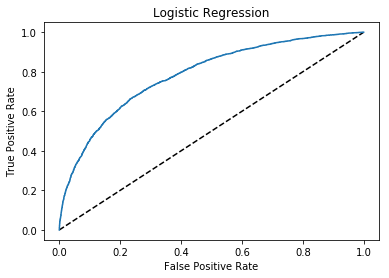

In [305]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr_21, tpr_lr_21, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression')
plt.show();

In [306]:
auc_score_lr_21 = roc_auc_score(y_test, y_pred_prob_lr_21)
auc_score_lr_21

0.784603121204721

## Precision Recall Curve

Because of the imbalanced class count, the 6th LogisticRegression algorithm is evaluated below with a Precision-Recall Curve, as recommended by this article by Jason Brownlee, PhD: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/. As Dr. Brownlee says, the future performance of a model with imbalanced class counts is better evaluated with a Precision-Recall Curve than an ROC curve. Specific modules are first imported for use in calculating the Precision-Recall Curve.

In [307]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

The precision recall curve is defined below, as is the F1 score and AUC for the precision-recall curve.

In [308]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_prob_lr_21)

In [309]:
lr_f1, lr_auc = f1_score(y_test, lr_pred_21), auc(lr_recall, lr_precision)

The F1 score is then called, as is the area under the Precision Recall Curve.

In [310]:
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

Logistic: f1=0.643 auc=0.688


The precision-recall curve is then plotted for the best Logistic Regression algorithm ('lr_21'). The precision-recall curve's AUC score (0.688) is lower than the ROC curve's AUC (0.785), showing that the model is moderately skilled at differentiating true positives from false positives and false negatives.

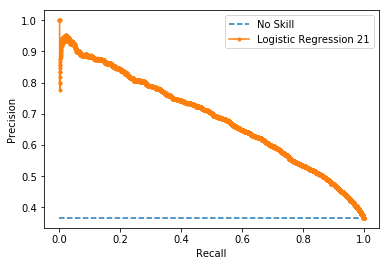

In [311]:
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic Regression 21')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Coefficients

In order to look at the most salient predictors of retained Ultimate customers, the feature set's coefficients for the best performing Logistic Regression algorithm ('lr_6') are identified to find the most predictive features differentiating retained customers from non-retained customers.

First, the coefficients are scaled as the features in the predictive feature set are of multiple scales, including binary, 5-point ratings, percentiles, and real integer numbers. 

First, the coefficients are called for all the features in the feature set, assigned to 'best_cf_coeffs' (short for 'best classifier's coefficients').

In [312]:
best_cf_coeffs = pd.Series(lr_21.coef_[0], index=X_train.columns) 
best_cf_coeffs

avg_dist                       -4.226198
avg_rating_by_driver           -0.736604
avg_rating_of_driver           -0.135395
avg_surge                       0.000000
surge_pct                       0.099906
trips_in_first_30_days         11.430859
ultimate_black_user             0.898293
weekday_pct                     0.056952
avg_rating_by_driver_isnull    -0.420210
avg_rating_of_driver_isnull    -0.658181
phone_isnull                    0.000000
signup_year                     0.000000
signup_month                    0.000000
signup_day                     -0.254383
last_trip_year                  0.000000
last_trip_day                   1.316944
city_Astapor                   -0.547105
city_Kings_Landing              1.236208
city_Winterfell                 0.000847
phone_Android                  -0.465624
phone_iPhone                    0.657578
phone_unknown_device            0.000000
dtype: float64

In [313]:
lr_21_coeffs_sorted = best_cf_coeffs.sort_values(ascending=False)
lr_21_coeffs_sorted

trips_in_first_30_days         11.430859
last_trip_day                   1.316944
city_Kings_Landing              1.236208
ultimate_black_user             0.898293
phone_iPhone                    0.657578
surge_pct                       0.099906
weekday_pct                     0.056952
city_Winterfell                 0.000847
phone_unknown_device            0.000000
avg_surge                       0.000000
phone_isnull                    0.000000
signup_year                     0.000000
signup_month                    0.000000
last_trip_year                  0.000000
avg_rating_of_driver           -0.135395
signup_day                     -0.254383
avg_rating_by_driver_isnull    -0.420210
phone_Android                  -0.465624
city_Astapor                   -0.547105
avg_rating_of_driver_isnull    -0.658181
avg_rating_by_driver           -0.736604
avg_dist                       -4.226198
dtype: float64

Second, the coefficients are scaled as the features in the predictive feature set are of multiple scales, including binary, 5-point ratings, percentiles, and real integer numbers. 

In [314]:
normalized_lr_21_coeffs = best_cf_coeffs/(X_train.max() - X_train.min())
normalized_lr_21_coeffs

avg_dist                       -4.226198
avg_rating_by_driver           -0.736604
avg_rating_of_driver           -0.135395
avg_surge                       0.000000
surge_pct                       0.099906
trips_in_first_30_days         20.124752
ultimate_black_user             0.898293
weekday_pct                     0.056952
avg_rating_by_driver_isnull    -0.420210
avg_rating_of_driver_isnull    -0.658181
phone_isnull                    0.000000
signup_year                          NaN
signup_month                         NaN
signup_day                     -0.254383
last_trip_year                       NaN
last_trip_day                   1.316944
city_Astapor                   -0.547105
city_Kings_Landing              1.236208
city_Winterfell                 0.000847
phone_Android                  -0.465624
phone_iPhone                    0.657578
phone_unknown_device            0.000000
dtype: float64

The features' coefficients are then sorted to show the features most predictive of retained Ultimate customers. The features with positive coefficients are more predictive of retained Ultimate customers, while the features with negative coefficients are more predictive of non-retained customers.

In [315]:
norm_best_coeffs = normalized_lr_21_coeffs.sort_values(ascending=False)
norm_best_coeffs

trips_in_first_30_days         20.124752
last_trip_day                   1.316944
city_Kings_Landing              1.236208
ultimate_black_user             0.898293
phone_iPhone                    0.657578
surge_pct                       0.099906
weekday_pct                     0.056952
city_Winterfell                 0.000847
phone_unknown_device            0.000000
phone_isnull                    0.000000
avg_surge                       0.000000
avg_rating_of_driver           -0.135395
signup_day                     -0.254383
avg_rating_by_driver_isnull    -0.420210
phone_Android                  -0.465624
city_Astapor                   -0.547105
avg_rating_of_driver_isnull    -0.658181
avg_rating_by_driver           -0.736604
avg_dist                       -4.226198
signup_year                          NaN
signup_month                         NaN
last_trip_year                       NaN
dtype: float64

As can be seen, there are several features with interesting logistic regression coefficients that can guide Ultimate's efforts to increase customer retention. These include:



- 'trips_in_first_30_days': 20.13  This feature has the highest positive coefficient, showing that customers are more likely to be retained if they take more trips in the first 30 days. This is a good sign for the Ultimate service, as it shows that customers are more likely to keep using the service if they took more trips in the first 30 days.

- 'last_trip_day': 1.32  This coefficient is hard to interpret, as it simply shows the day of the last trip, divorced from the month.

- 'city_Kings_Landing': 1.24  This coefficient shows again that King's Landing customers are more likely to be retained. This finding warrants further research.

- 'ultimate_black_user': 0.9  This coefficient shows that customers are more likely to be retained if they use the Ultimate Black service. This shows that Ultimate should do more to support and advertise the Ultimate Black service in order to increase customer retention.

- 'phone_iPhone': 0.66  This coefficient again shows that there are UX design factors with using Ultimate on an iPhone that make it a more positive experience. Further UX research and design should be used to support the service on the iPhone platform.

- 'phone_Android': -0.47  This coefficient again shows that there are UX design factors with using Ultimate on an Androdi phone that make it a more negative experience. Again, further UX research and design should be used to support the service on the Android platform, and this research and design should be informed by how the service is set up on the iPhone platform.

- 'city_Astapor': -0.55  This coefficient again shows that Astapor customers are less likely to be retained. This warrants further research.

- 'avg_rating_by_driver': -0.74  This coefficient shows, counterintuitively, that the higher a rider's rating is, the less likely they are to be a retained customer. This warrants further research, but may just be noise as the vast majority of riders have close to a 5-point rating.

- 'avg_dist': -4.23  This coefficient shows that the longer Ultimate rides are in terms of distance, the less likely Ultimate users are to be retained. This is a very salient finding that warrants further research, as long rides are lucrative for the company and the driver, but there is something negative about experiencing a long Ultimate ride. 

These features are the most important features in predicting customer retention for Ultimate.
